# Near-infrared scan analysis

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL.Image
import PIL.ExifTags
import re

from math import cos, sin

In [4]:
pole_ids = [0, 30, 41, 6, 5]
rotations = [0, 90, 180, 270]
pole_status = ['31/37', '17/24', '15/24', '12/24', '11/24']

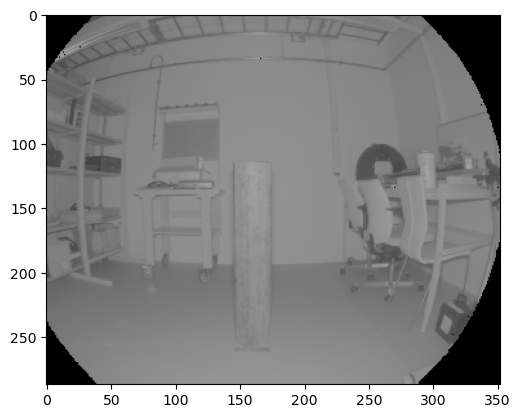

In [3]:
image = cv2.imread('LiDAR/0/2d/0/Frame_15631.intens.gray.png')
plt.imshow(image)

## EXIF data, in case there is something relevant there

In [4]:
def get_exif(image_path):
    img = PIL.Image.open(image_path)
    try:
        exif = {
            PIL.ExifTags.TAGS[k]: v
            for k, v in img._getexif().items()
            if k in PIL.ExifTags.TAGS
        }
        return exif
    except AttributeError:
        print("No EXIF data available!")
        return None

In [5]:
get_exif('LiDAR/0/2d/0/Frame_15631.intens.gray.png')

No EXIF data available!


## A general look at all the NIR images

Taking a look at all the near-infrared scan images at once might help at getting a general glimpse of some relevant patterns that might help with pole status prediction

In [5]:
def plot_scans(ids, rotations):
    fig, axes = plt.subplots(5,4,figsize=(20,20))
    scan_regex = re.compile(r'^Frame_[0-9]+\.intens.gray.png')
    
    for pole_idx, pole_id in enumerate(ids):
        for rot_idx, rot in enumerate(rotations):
            paths = os.listdir(f'LiDAR/{pole_id}/2d/{rot}')
            scan_path = [path for path in paths if re.fullmatch(scan_regex, path)][0]
            image = cv2.imread(f'LiDAR/{pole_id}/2d/{rot}/{scan_path}', cv2.IMREAD_GRAYSCALE)
            axes[pole_idx, rot_idx].imshow(image, vmin=0, vmax=255, cmap='gray')
            axes[0, rot_idx].set_title(f'{rot} degrees')
        axes[pole_idx, 0].set_ylabel(f'Pole {pole_id}\nStatus: {pole_status[pole_idx]}', labelpad=50, fontdict={'rotation':0})
    plt.savefig('nir-grid.png')

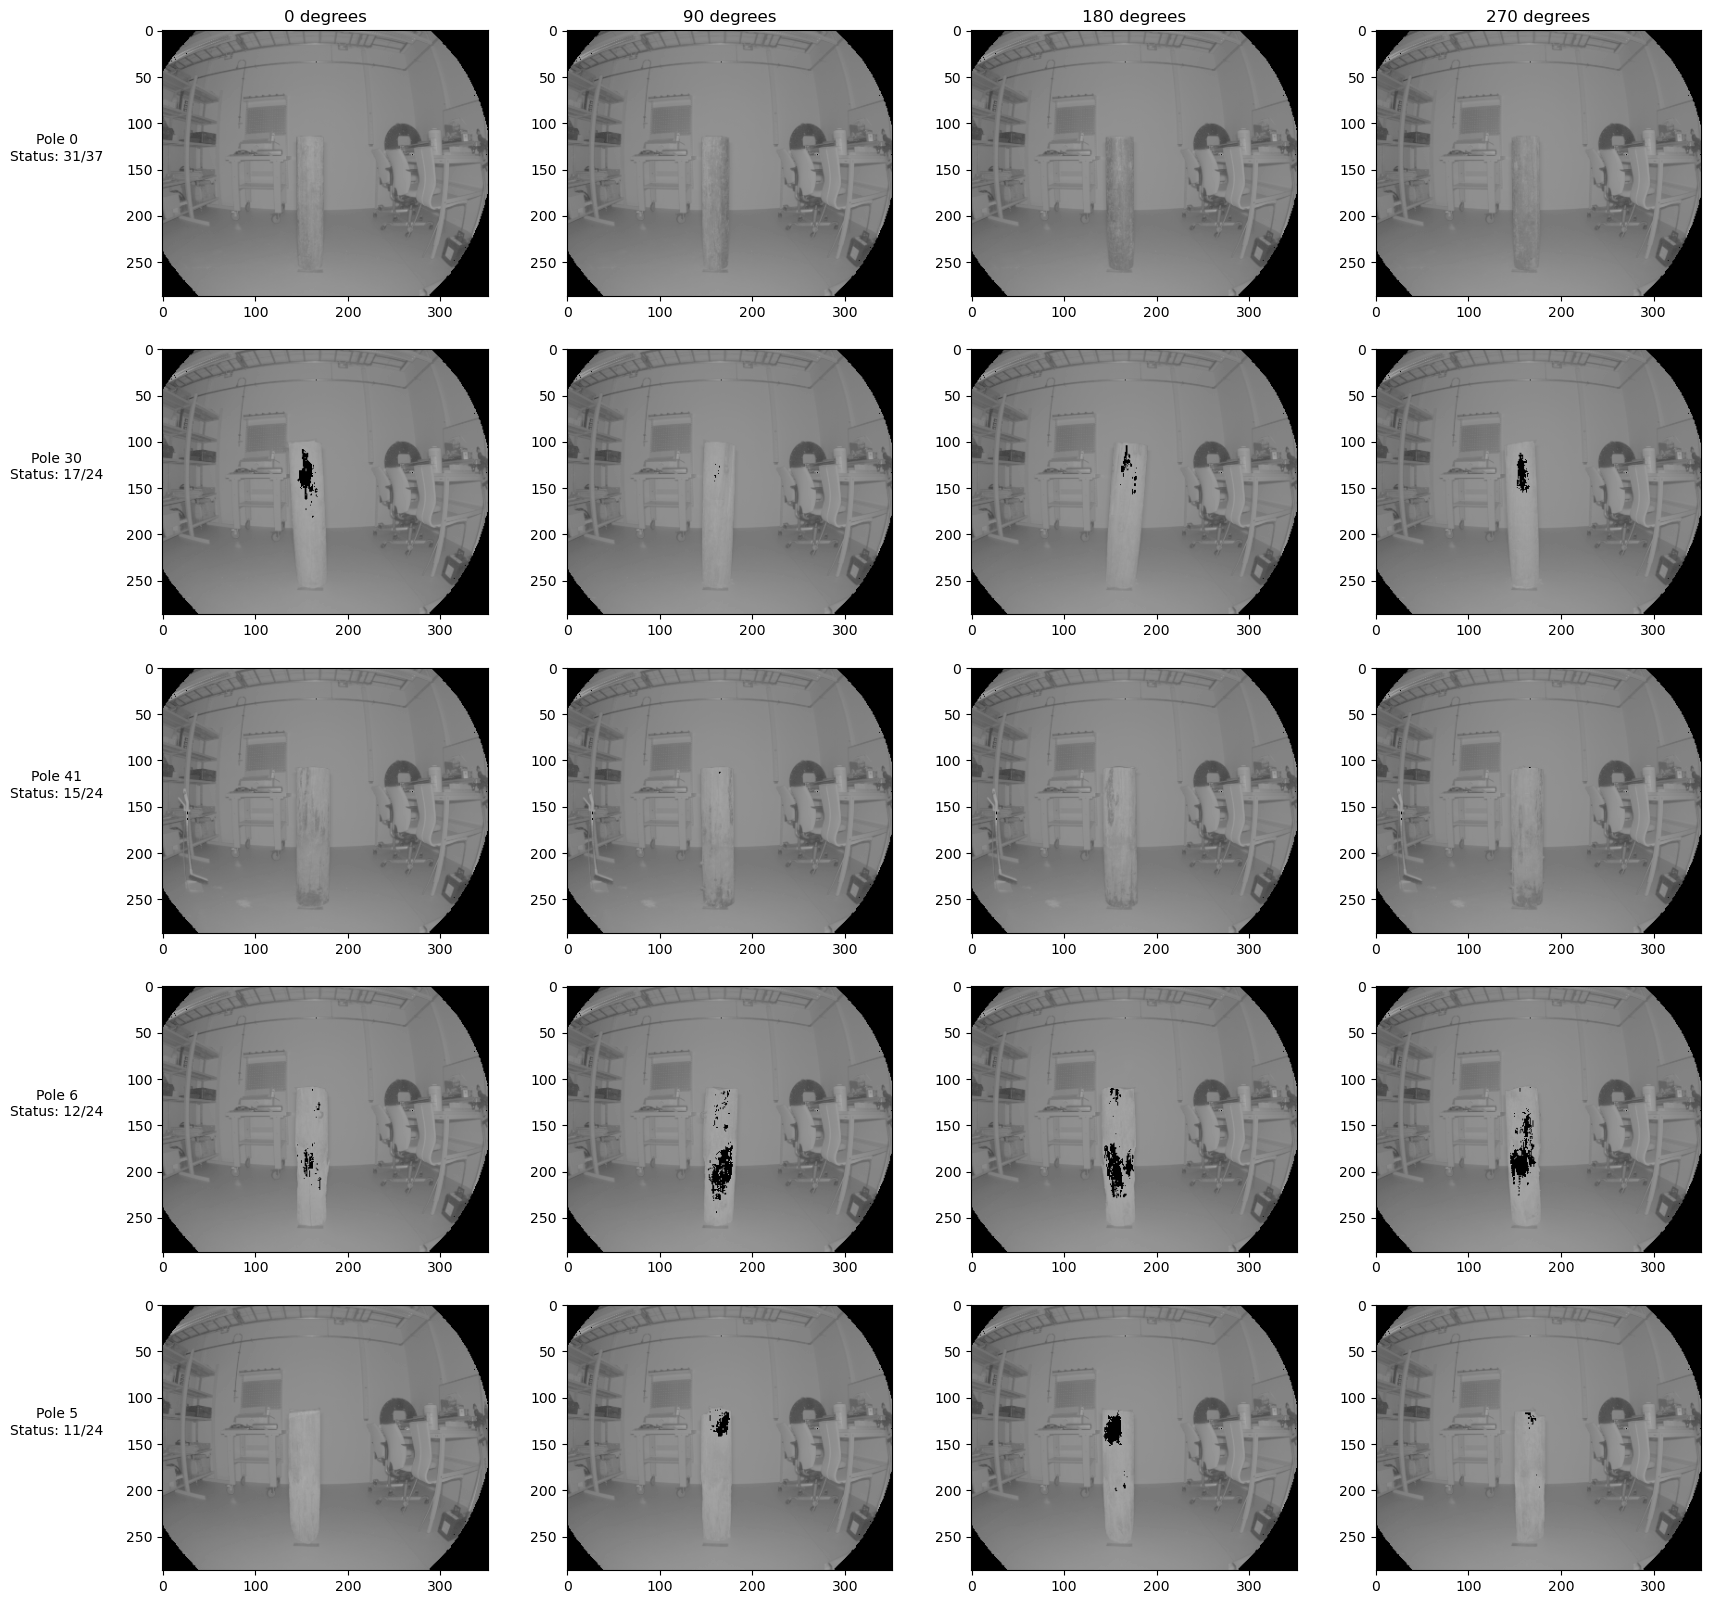

In [6]:
plot_scans(pole_ids, rotations)

The most highlitable characteristic here is that, for some poles, there are random black spots. This might have to do with their status, as the new pole does not present any black area, even though pole 41 does not either.

## Verify frame differences

Since there are 5 frames of each pole/rotation pair, it is a good idea to verify that these are as similar as possible

In [160]:
def verify_differences(ids, rotations):
    scan_regex = re.compile(r'^Frame_[0-9]+\.intens.gray.png')
    fig, axes = plt.subplots(20, 10, figsize=(30,50))
    pole_rot_idx = 0
    for idx, pole_id in enumerate(ids):
        for rot in rotations:
            pair_idx = 0
            paths = os.listdir(f'LiDAR/{pole_id}/2d/{rot}')
            scan_paths = [path for path in paths if re.fullmatch(scan_regex, path)]
            diff_sum = 0
            max_diff = 0
            for path_idx_1 in range(len(scan_paths)-1):
                for path_idx_2 in range(path_idx_1 + 1, len(scan_paths)):
                    img1 = cv2.imread(f'LiDAR/{pole_id}/2d/{rot}/{scan_paths[path_idx_1]}', cv2.IMREAD_GRAYSCALE)
                    img2 = cv2.imread(f'LiDAR/{pole_id}/2d/{rot}/{scan_paths[path_idx_2]}', cv2.IMREAD_GRAYSCALE)
                    diff = cv2.absdiff(img1, img2)
                    diff_sum += np.sum(diff)
                    max_diff = max(max_diff, np.max(diff))
                    axes[pole_rot_idx, pair_idx].imshow(diff, cmap='gray', vmin=0, vmax=255)
                    axes[0, pair_idx].set_title(f'abs({path_idx_1} - {path_idx_2})')
                    pair_idx += 1
            axes[pole_rot_idx, 0].set_ylabel(f'Pole {pole_id}, rotation {rot}\nStatus: {pole_status[idx]}\nDiff sum: {diff_sum}\nMax diff: {max_diff}', labelpad=50, fontdict={'rotation':0})
            pole_rot_idx += 1
            
    plt.tight_layout()
    plt.savefig('nir-differences.png')

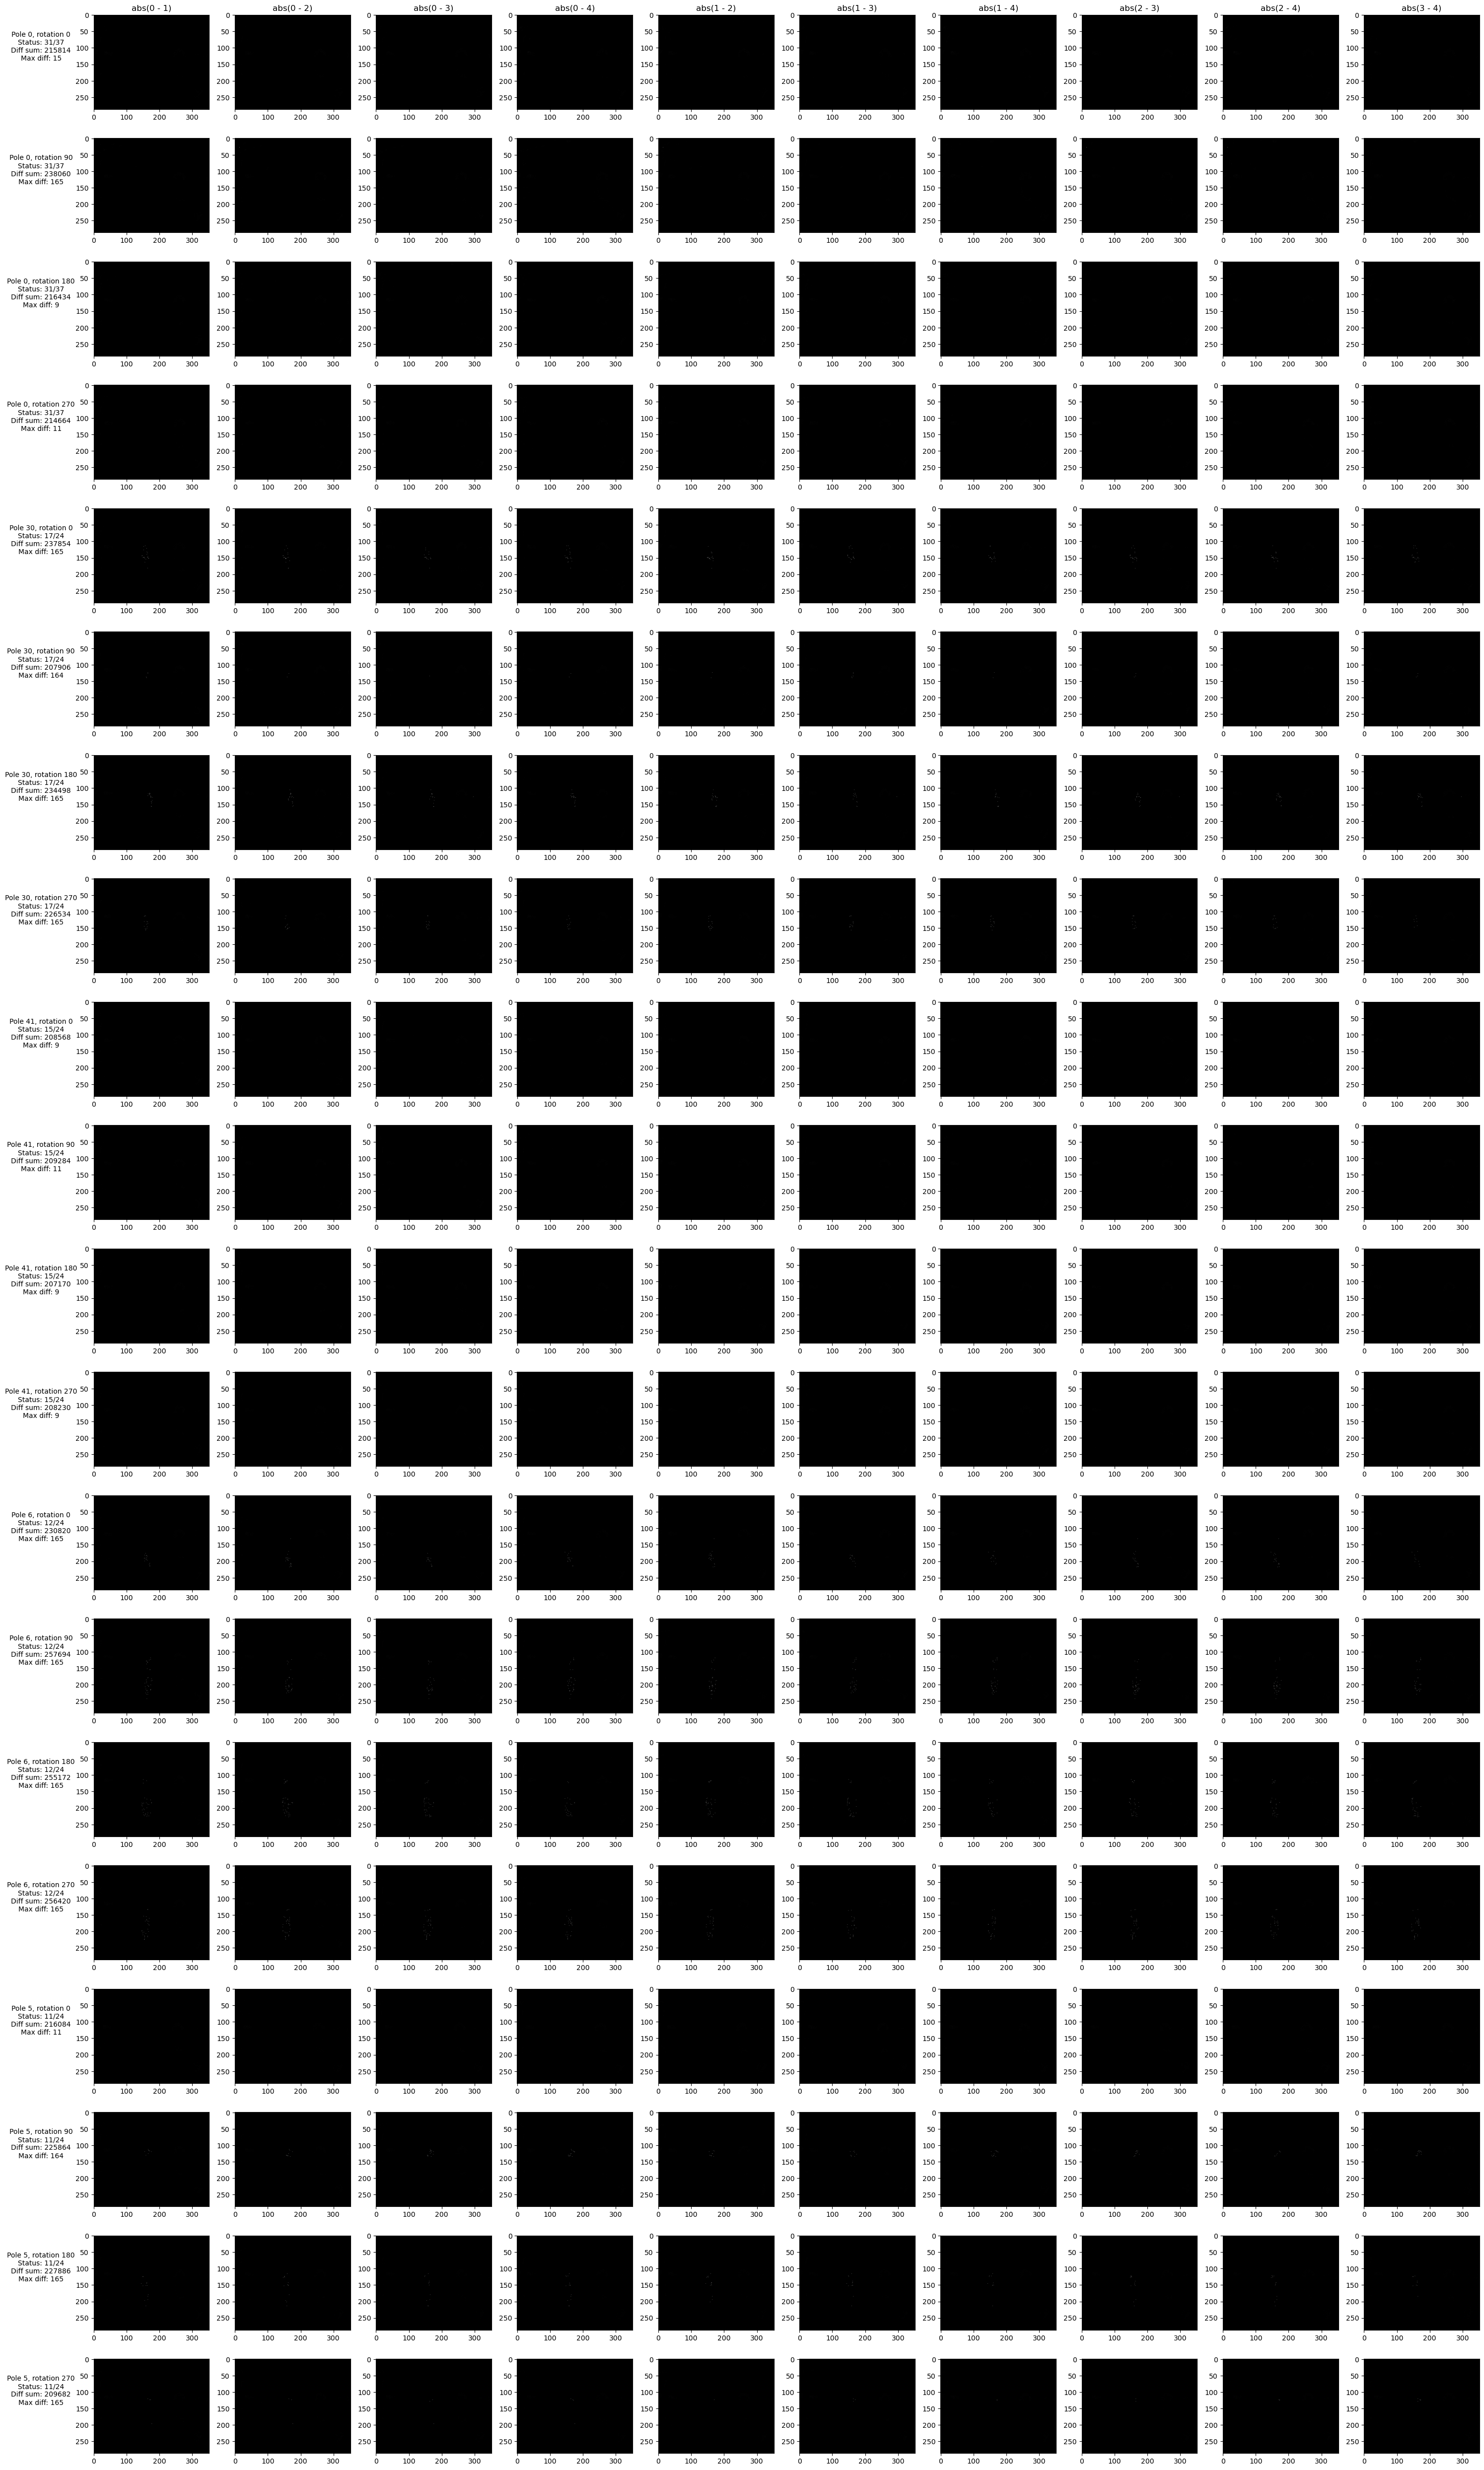

In [161]:
verify_differences(pole_ids, rotations)

For checking differences among the different frames, all pairs of frames per pole-rotation pair have been taken. In this figure, each row represents a pole-rotation pair, and each column represents a certain frame pair. These results seem to show that, for some poles, there are sudden peaks of frame differences. It could be interesting to see these spikes together with the poles

In [158]:
def overlap_diff_with_poles(ids, rotations):
    scan_regex = re.compile(r'^Frame_[0-9]+\.intens.gray.png')
    fig, axes = plt.subplots(5, 4, figsize=(20,20))
    for pole_idx, pole_id in enumerate(ids):
        for rot_idx, rot in enumerate(rotations):
            paths = os.listdir(f'LiDAR/{pole_id}/2d/{rot}')
            scan_paths = [path for path in paths if re.fullmatch(scan_regex, path)]
            diff_pairs = []
            for path_idx_1 in range(len(scan_paths)-1):
                for path_idx_2 in range(path_idx_1 + 1, len(scan_paths)):
                    img1 = cv2.imread(f'LiDAR/{pole_id}/2d/{rot}/{scan_paths[path_idx_1]}', cv2.IMREAD_GRAYSCALE)
                    img2 = cv2.imread(f'LiDAR/{pole_id}/2d/{rot}/{scan_paths[path_idx_2]}', cv2.IMREAD_GRAYSCALE)
                    diff = cv2.absdiff(img1, img2)
                    diff_pairs.append(diff)
            avg_diff = np.average(diff_pairs, axis=0).astype(int)
            first_frame = cv2.imread(f'LiDAR/{pole_id}/2d/{rot}/{scan_paths[0]}', cv2.IMREAD_GRAYSCALE)
            axes[pole_idx, rot_idx].imshow(first_frame, alpha=0.5, cmap='gray', vmin=0, vmax=255)
            axes[pole_idx, rot_idx].imshow(avg_diff, alpha=0.5, cmap='hot', vmin=0, vmax=255)
            axes[0, rot_idx].set_title(f'{rot} degrees')
        axes[pole_idx, 0].set_ylabel(f'Pole {pole_id}\nStatus: {pole_status[pole_idx]}', labelpad=50, fontdict={'rotation':0})
            
    plt.tight_layout()
    plt.savefig('nir-diff-overlay.png')

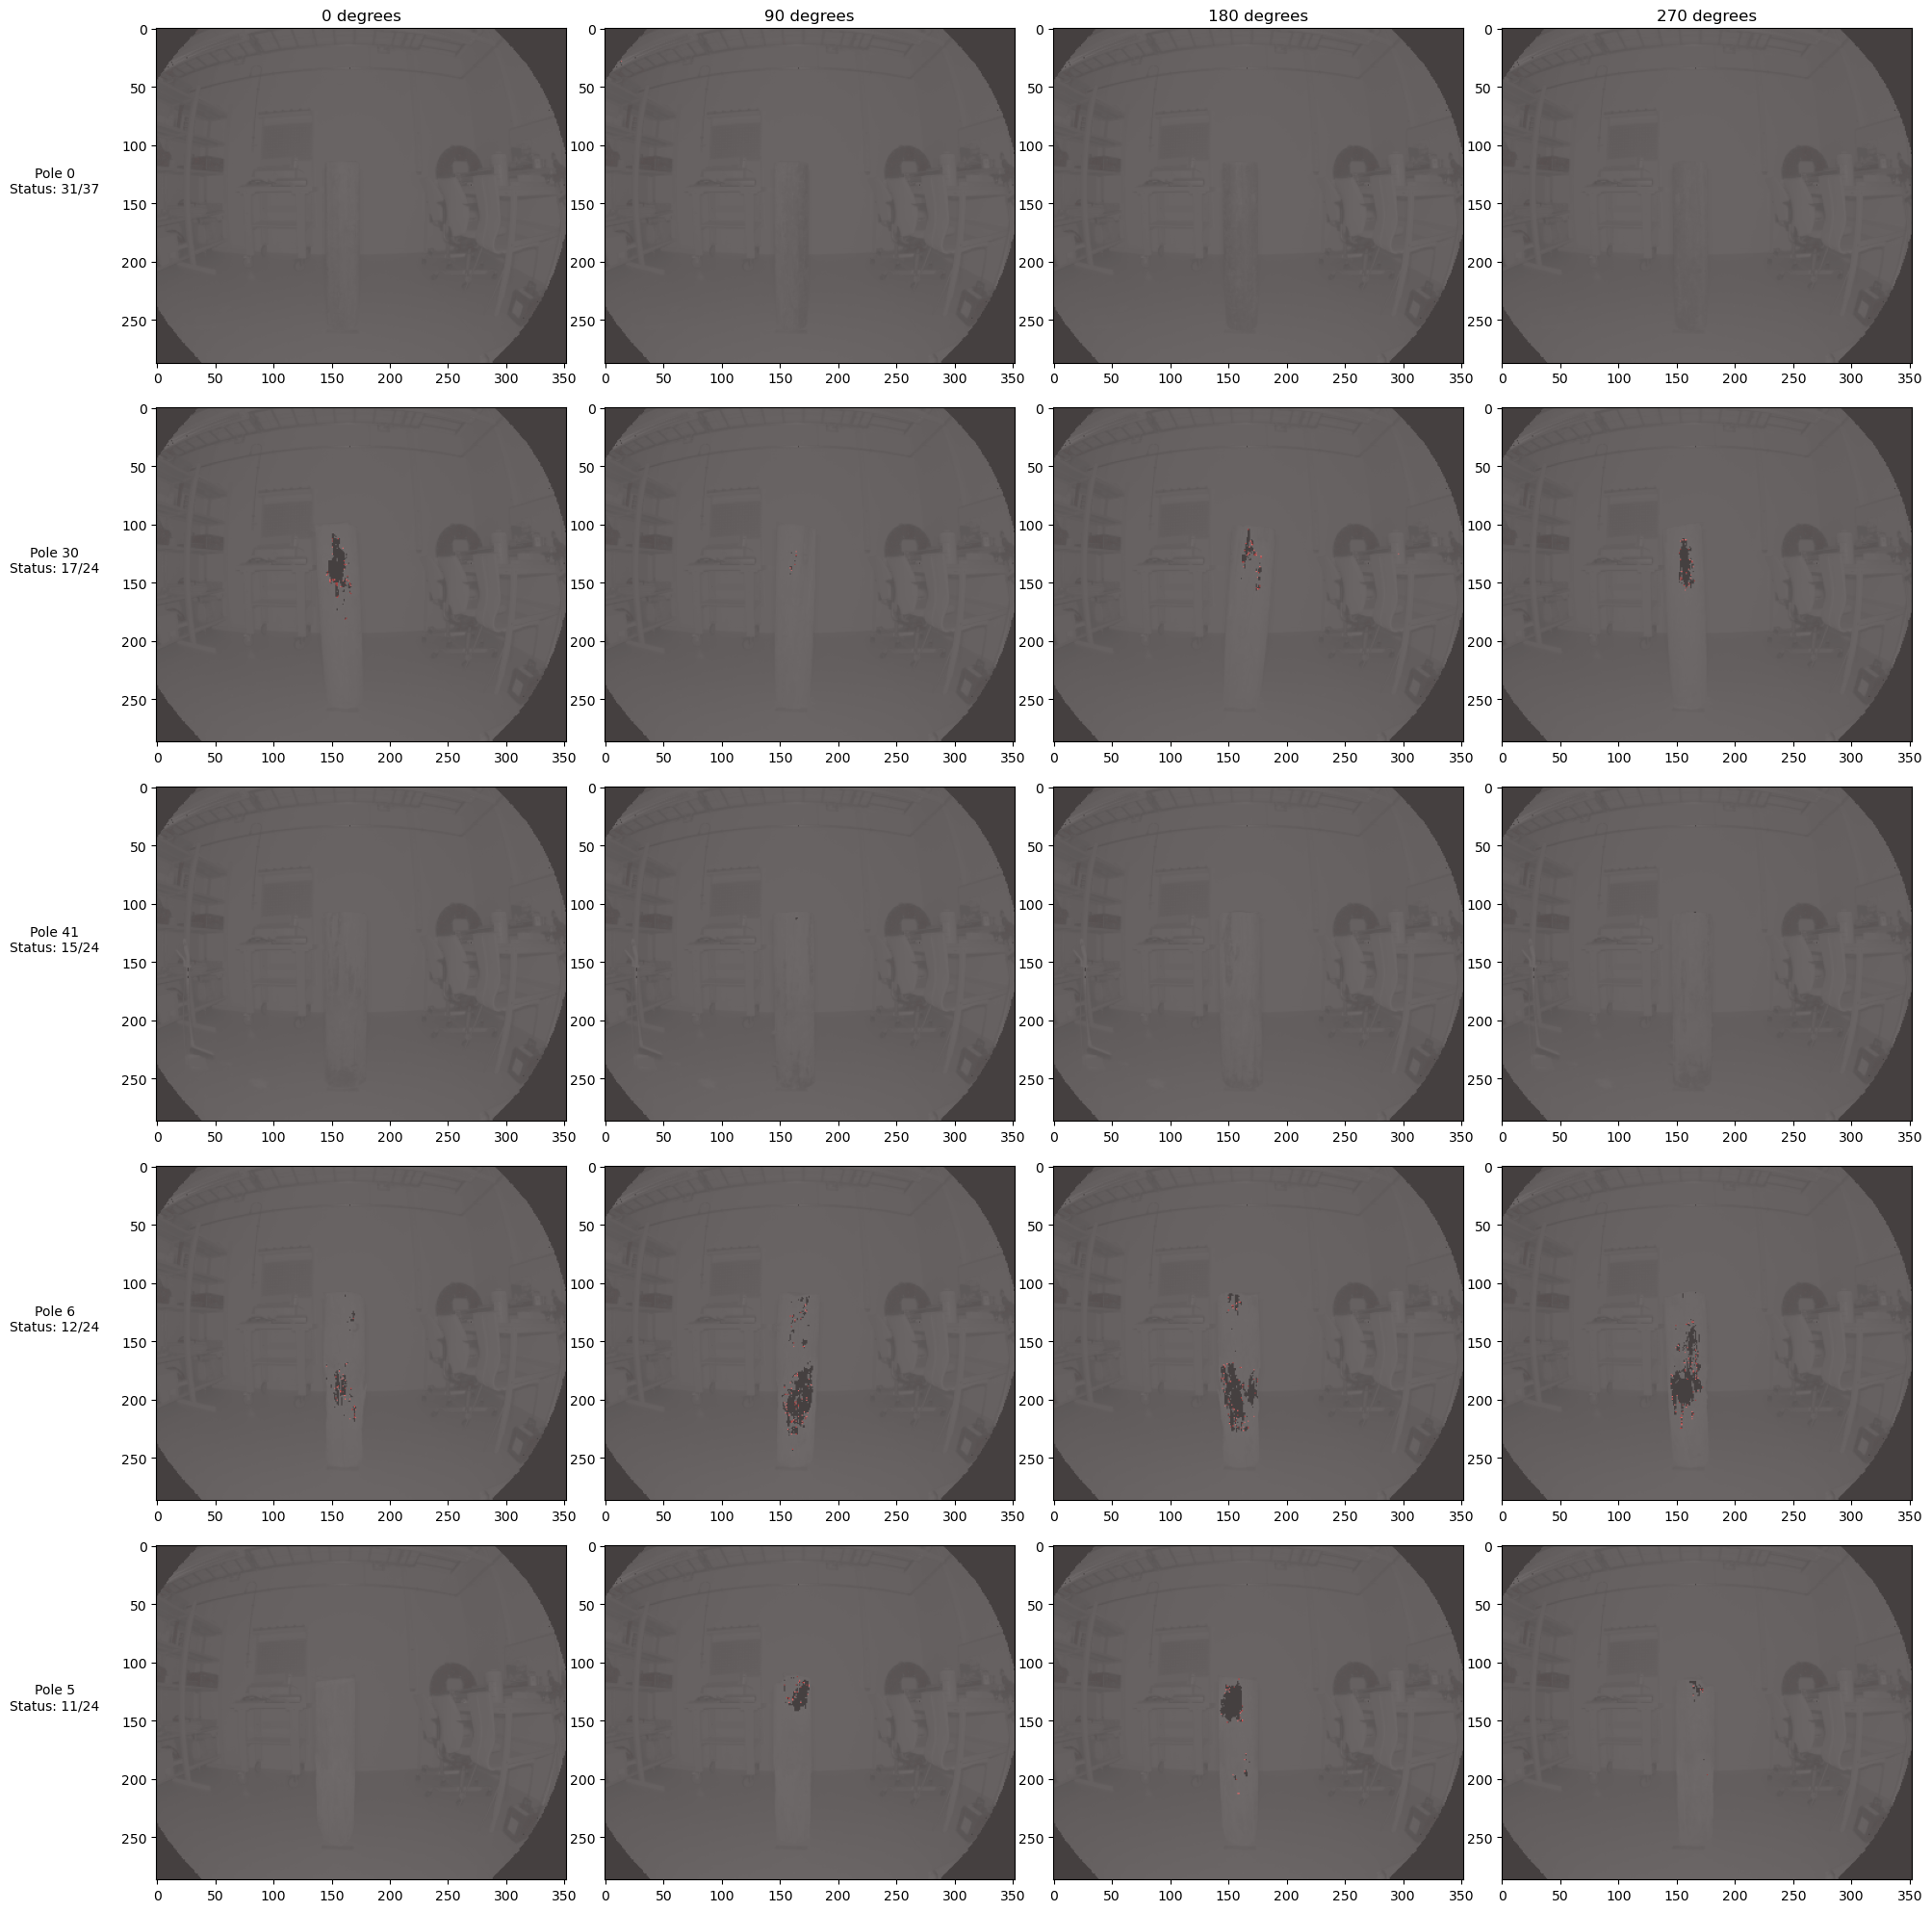

In [159]:
overlap_diff_with_poles(pole_ids, rotations)

This figure shows an overlap of the first frame for each pole-rotation pair with the average difference between all frame pairs for that same pole-rotation pair. As it can be seen, for poles with dark areas, the differences are mostly concentrated around the black area, whereas for poles with no dark areas, there are no significant frame differences (and maximum differences are usually not higher than 20).

I'm not sure why these dark spots appear. I have consulted Arnaud, and it is not clear if these spots could be due to some bad measurement procedure. **Is there a way of verifying what is causing these black areas?**